In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [0]:
# image reshaping and input image normaliztion
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255




Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 2)                 6274      
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________


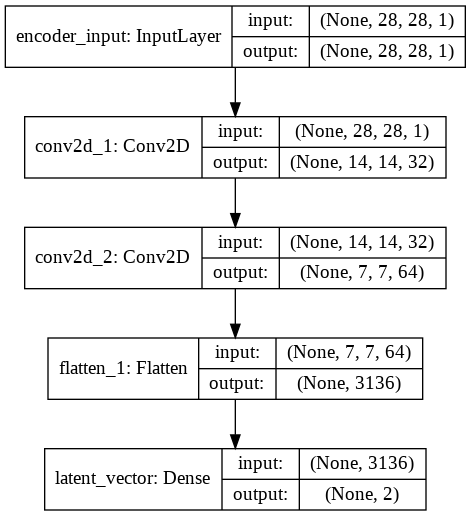

In [3]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 2

# cnn 계층당 필터의 인코더/디코더의 수
layer_filters = [32, 64]

# Autoencoder model: Encoder 구성
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Conv2D(32) ~ Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

shape = K.int_shape(x)

# latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Encoder 모델 인스턴스화
encoder = Model(inputs, latent, name='encoder')
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

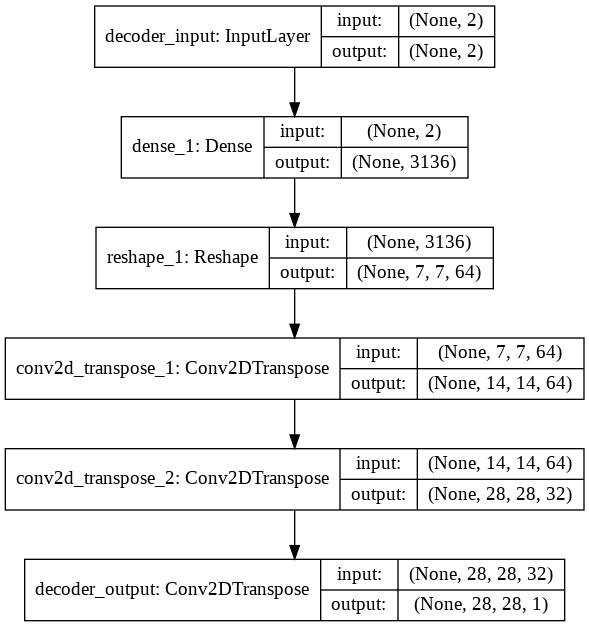

In [4]:
# Autoencoder model: Decoder 구성
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Conv2D(64) ~ Conv2D(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# 입력 재구성
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# Decoder model 인스턴스화
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 2)                 25090     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         65089     
Total params: 90,179
Trainable params: 90,179
Non-trainable params: 0
_________________________________________________________________


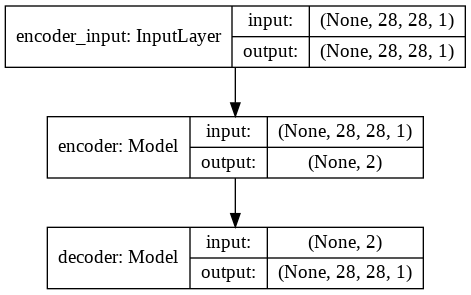

In [5]:
# Autoencoder model 인스턴스화
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

In [6]:
# Mean Square Error, MSE / Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=20,
                batch_size=batch_size)





Train on 60000 samples, validate on 10000 samples
Epoch 1/20





60000/60000 [==============================] - 13s 214us/step - loss: 0.0540 - val_loss: 0.0470
Epoch 2/20
60000/60000 [==============================] - 10s 172us/step - loss: 0.0458 - val_loss: 0.0446
Epoch 3/20
60000/60000 [==============================] - 10s 175us/step - loss: 0.0443 - val_loss: 0.0437
Epoch 4/20
60000/60000 [==============================] - 10s 172us/step - loss: 0.0435 - val_loss: 0.0430
Epoch 5/20
60000/60000 [==============================] - 10s 174us/step - loss: 0.0430 - val_loss: 0.0428
Epoch 6/20
60000/60000 [==============================] - 10s 174us/step - loss: 0.0426 - val_loss: 0.0424
Epoch 7/20
60000/60000 [==============================] - 10s 174us/step - loss: 0.0422 - val_loss: 0.0421
Epoch 8/20
60000/60000 [==============================] - 10s 173us/step - loss: 0.0420 - val_loss: 0.0419
Epoch 9/20
60000/60000 [==============================] - 11s 179us/step - loss: 0.04

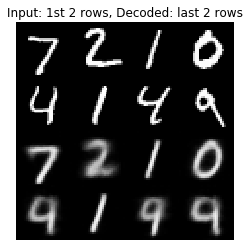

In [7]:
# 출력 예측
x_decoded = autoencoder.predict(x_test)

# 이미지 plot
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

In [0]:
import os

def plot_results(models,
                 data,
                 batch_size=32,
                 model_name="autoencoder_2dim"):
    """Plots 2-dim latent values as color gradient
        then, plot MNIST digits as function of 2-dim latent vector
    Arguments:
        models (list): encoder and decoder models
        data (list): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "latent_2dim.png")
    # display a 2D plot of the digit classes in the latent space
    z = encoder.predict(x_test,
                        batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z[:, 0], z[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of the digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            x_decoded = decoder.predict(z)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

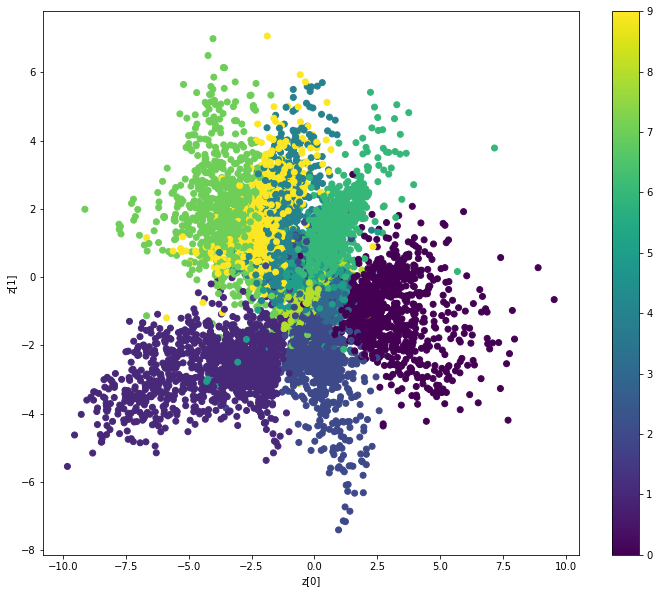

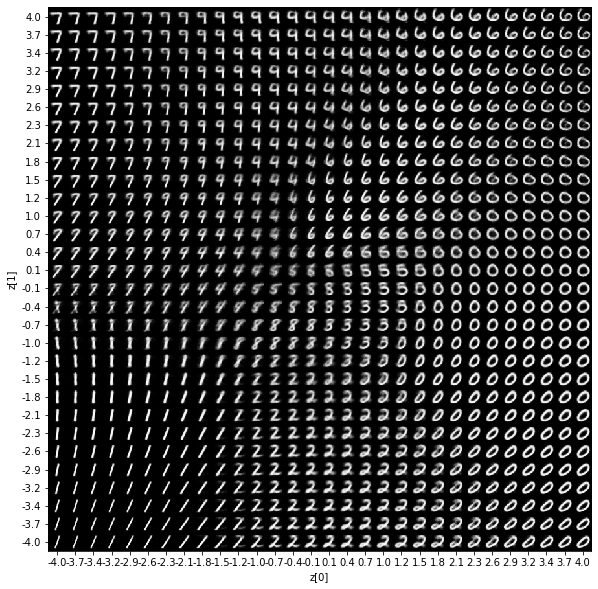

In [9]:
# project the 2-dim latent on 2D space
models = (encoder, decoder)
data = (x_test, y_test)


plot_results(models, data,
             batch_size=batch_size,
             model_name="autonencoder-2dim")